In [ ]:
DATA_LOCATION = './data/data3node.txt'
LIST_LOCATION = './data/lists_3nodes.txt'
RESULTS_LOCATION = './data/results_3nodes.txt'
# This makes the compiler not yell at me, because I don't have a gpu
CUDA_VISIBLE_DEVICES = -1

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2023-02-08 16:03:23.729791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 16:03:23.893310: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 16:03:23.893335: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-08 16:03:24.899289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

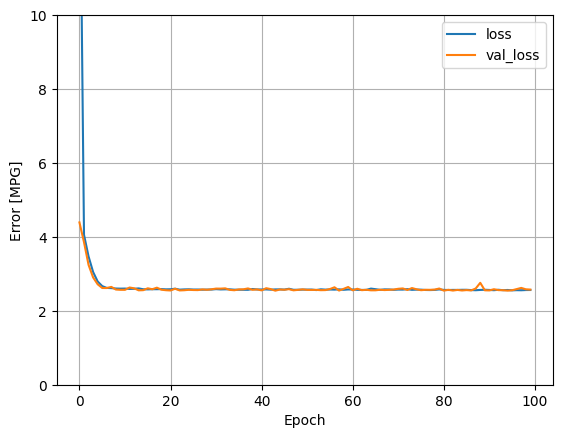

In [1]:
np.set_printoptions(precision=3, suppress=True)
normalizer = tf.keras.layers.Normalization(axis=-1)

def preprocess():
    data = []
    results = []

    with open(LIST_LOCATION) as listFile:
        with open(RESULTS_LOCATION) as resFile:
            for lis, res in zip(listFile,resFile):
                intList = list(map(int, lis[:-1].split(',')))

                results.append(int(res[:-1]))
                data.append(intList)

    return pd.DataFrame(data), pd.DataFrame(results)

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)



In [8]:
data, res = preprocess()
dat_trn, dat_tst, res_trn, res_tst = train_test_split(data, res, test_size=0.2, random_state=42)

normalizer.adapt(dat_trn)

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [9]:
history = dnn_model.fit(
    dat_trn,
    res_trn,
    validation_split=0.2,
    verbose=0, epochs=100)

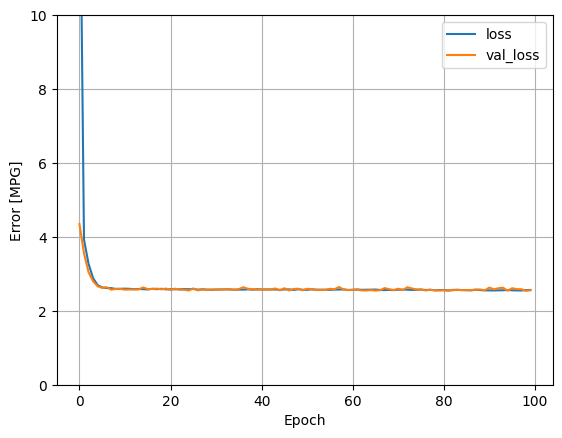

In [10]:
plot_loss(history)

In [12]:
dnn_model.evaluate(dat_tst, dat_tst, verbose=0)

17.186321258544922

50/50 [==============================] - 0s 2ms/step


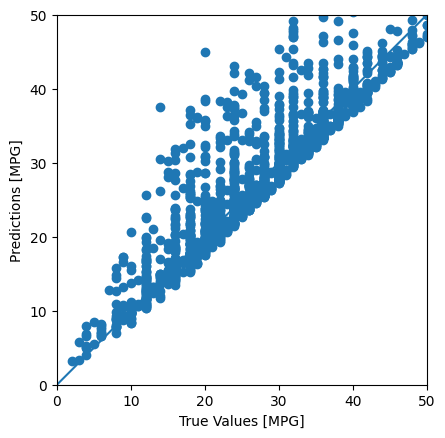

In [24]:
test_predictions = dnn_model.predict(dat_tst).flatten()

a = plt.axes(aspect='equal')
plt.scatter(res_tst.T, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

       2215     2582      1662     3027      4343     2680      1765  \
0 -1.153299 -1.61248 -1.671622  7.69725 -1.305372 -0.50145 -0.151126   

       1123      4054      3761  ...      4993       231       1941      6880  \
0 -2.008707  0.680004 -0.207699  ... -0.832619  10.731134 -0.526083 -0.688456   

       7241      1079       7979       1115      6093      6832  
0 -1.671869 -1.223995  13.590927  12.834513 -1.321768 -0.271744  

[1 rows x 1600 columns]


Text(0, 0.5, 'Count')

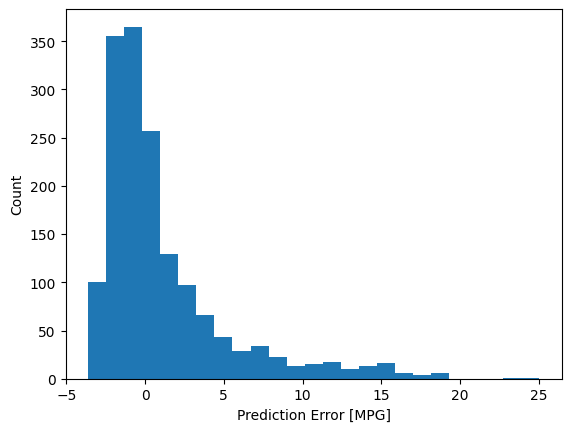

In [31]:
error = test_predictions - res_tst.T
print(error)

plt.hist(error.T, bins=25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')